In [1]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python

import matplotlib.pyplot as plt # for charts and such
    
import datetime as dt  # for dealing with times

import time
from datetime import date, timedelta, datetime


## Historical Cryptocurrency Data

In [2]:
#URL for binance API
root_url = 'https://api.binance.com/api/v1/klines'
start_date = 93 #95 as of 3/2/21. Adjust by number of days since 3/1. curr_pct_change below should start 1/22/20
end_date = 469 #497 as of 3/2/21.


In [3]:
#function to pull data from binance API
def get_bars(symbol, interval = '1d'):
    url = root_url + '?symbol=' + symbol + '&interval=' + interval
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'open', 'high', 'low', 'close', 'volume',
                 'close_time', 'qav', 'num_trades',
                 'taker_base_vol', 'taker_quote_vol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
    df = df[[ 'open', 'high', 'low', 'close', 'volume', 'num_trades']]
    return df

#### Currency Sector

In [4]:
#array to store each coin's closing prices series
coins = []
#creates Bitcoin Dataframe
btcusdt = get_bars('BTCUSDT')
#creates Bitcoin Cash Dataframe
bchusdt = get_bars('BCHUSDT')
#creates Litcoin Dataframe
ltcusdt = get_bars('LTCUSDT')

#create Pandas series for each coin's closing prices
btcclose = btcusdt.close.astype(float)
bchclose = bchusdt.close.astype(float)
ltcclose = ltcusdt.close.astype(float)
coins.extend([btcclose, bchclose, ltcclose])

currency_agg = pd.DataFrame([btcclose.pct_change(), bchclose.pct_change(), ltcclose.pct_change()])
curr_pct_change = currency_agg.groupby(currency_agg.index).mean()


In [5]:
curr_pct_change = curr_pct_change.loc["close"].iloc[start_date:end_date]
# series.loc[["2020-01-22 17:59:59.999","2021-02-03 17:59:59.999"]]
curr_pct_change


2020-01-22 17:59:59.999    0.007903
2020-01-23 17:59:59.999   -0.055357
2020-01-24 17:59:59.999   -0.006028
2020-01-25 17:59:59.999   -0.019910
2020-01-26 17:59:59.999    0.070645
                             ...   
2021-01-27 17:59:59.999   -0.091064
2021-01-28 17:59:59.999    0.086776
2021-01-29 17:59:59.999    0.014194
2021-01-30 17:59:59.999    0.005092
2021-01-31 17:59:59.999   -0.035544
Name: close, Length: 376, dtype: float64

#### Infrastructure Sector

In [6]:
#creates Etherium Dataframe
ethusdt = get_bars('ETHUSDT')
#creates Cardano Dataframe
adausdt = get_bars('ADAUSDT')
#creates EOS Dataframe
eosusdt = get_bars('EOSUSDT')


ethclose = ethusdt.close.astype(float)
adaclose = adausdt.close.astype(float)
eosclose = eosusdt.close.astype(float)

#get average % change
coins.extend([ethclose, adaclose, eosclose])
infra_agg = pd.DataFrame([ethclose.pct_change(), adaclose.pct_change(), eosclose.pct_change()])
infra_pct_change = infra_agg.groupby(infra_agg.index).mean()
test_2019 = infra_pct_change
infra_pct_change = infra_pct_change.loc["close"].iloc[start_date:end_date]
infra_pct_change

2020-01-22 17:59:59.999   -0.004630
2020-01-23 17:59:59.999   -0.036765
2020-01-24 17:59:59.999    0.019076
2020-01-25 17:59:59.999   -0.030432
2020-01-26 17:59:59.999    0.042557
                             ...   
2021-01-27 17:59:59.999   -0.078110
2021-01-28 17:59:59.999    0.087187
2021-01-29 17:59:59.999    0.017557
2021-01-30 17:59:59.999    0.041003
2021-01-31 17:59:59.999   -0.033722
Name: close, Length: 376, dtype: float64

In [7]:
test_2019 = test_2019.loc["close"].iloc[0:start_date]

#### Financial Sector

In [8]:
#creates Chainlink Dataframe
linkusdt = get_bars('LINKUSDT')
#creates BNB Dataframe
bnbusdt = get_bars('BNBUSDT')
#creates 0x Dataframe
zrxusdt = get_bars('ZRXUSDT')


linkclose = linkusdt.close.astype(float)
bnbclose = bnbusdt.close.astype(float)
zrxclose = zrxusdt.close.astype(float)
coins.extend([linkclose, bnbclose, zrxclose])

#get average % change
coins.extend([ethclose, adaclose, eosclose])
fin_agg = pd.DataFrame([linkclose.pct_change(), bnbclose.pct_change(), zrxclose.pct_change()])
fin_pct_change = fin_agg.groupby(fin_agg.index).mean()
fin_pct_change = fin_pct_change.loc["close"].iloc[start_date:end_date]


#### Services Sector

In [9]:
#creates Numeraire Dataframe
nmrusdt = get_bars('NMRUSDT')
#creates Enjin Coin Dataframe
enjusdt = get_bars('ENJUSDT')
#creates Siacoin Dataframe
scusdt = get_bars('SCUSDT')


nmrclose = nmrusdt.close.astype(float)
enjclose = enjusdt.close.astype(float)
scclose = scusdt.close.astype(float)
coins.extend([nmrclose, enjclose, scclose])

#get average % change
coins.extend([ethclose, adaclose, eosclose])
serv_agg = pd.DataFrame([nmrclose.pct_change(), enjclose.pct_change(), scclose.pct_change()])
serv_pct_change = serv_agg.groupby(serv_agg.index).mean()
serv_pct_change = serv_pct_change.loc["close"].iloc[start_date:end_date]


#### Media and Entertainment Sector

In [10]:
#creates Basic Attention Dataframe
batusdt = get_bars('BATUSDT')
#creates Steem Dataframe
steembtc = get_bars('STEEMBTC')
#convert from steem/btc to steem/usd 
steemusdt = steembtc[['open', 'high', 'low', 'close']].astype('float') * btcusdt[['open', 'high', 'low', 'close']].astype('float')
#creates Fun Fair Dataframe
funusdt = get_bars('FUNUSDT')


batclose = batusdt.close.astype(float)
steemclose = steemusdt.close.astype(float)
funclose = funusdt.close.astype(float)
coins.extend([batclose, steemclose, funclose])

#get average % change
coins.extend([ethclose, adaclose, eosclose])
med_agg = pd.DataFrame([batclose.pct_change(), steemclose.pct_change(), funclose.pct_change()])
med_pct_change = med_agg.groupby(med_agg.index).mean()
med_pct_change = med_pct_change.loc["close"].iloc[start_date:end_date]


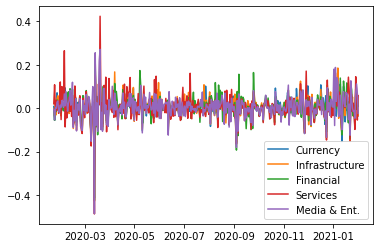

In [11]:
plt.plot(curr_pct_change, label='Currency')
plt.plot(infra_pct_change, label='Infrastructure')
plt.plot(fin_pct_change, label='Financial')
plt.plot(serv_pct_change, label='Services')
plt.plot(med_pct_change, label='Media & Ent.')
plt.legend()
plt.show()

pct_change = [curr_pct_change, infra_pct_change, fin_pct_change, serv_pct_change, med_pct_change]

## New COVID-19 Cases and Deaths (Per Million)

In [80]:
#CASES
new_cases_permil_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_cases_per_million.csv"
new_cases_permil = pd.read_csv(new_cases_permil_url)

global_cases = new_cases_permil.loc[:]["World"]
global_cases = global_cases[:376]
global_cases.index = date_index
global_cases = global_cases.shift(1)
global_cases.iloc[0] = 0

#DEATHS
new_deaths_permil_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_deaths_per_million.csv"
new_deaths_permil = pd.read_csv(new_deaths_permil_url)

global_deaths = new_deaths_permil.loc[:]["World"]
global_deaths = global_deaths[:376]
global_deaths.index = date_index
global_deaths = global_deaths.shift(1)
global_deaths.iloc[0] = 0



In [81]:
# #GLOBAL CONFIRMED COVID DEATHS PLOT
# global_deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
# gd_df = pd.read_csv(global_deaths_url, error_bad_lines=False)
# plt.plot(gd_df.iloc[0:, 4:].sum(axis=0))

# #GATHER AND REINDEX COVID CASE DATA FROM 1/22-10/31
# global_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
# gc_df = pd.read_csv(global_cases_url, error_bad_lines=False)
# covid_cases = gc_df.iloc[0:, 4:].sum(axis=0)
# covid_cases = covid_cases.shift(1)     #shift to use preceding day as feature in LSTM
# covid_cases.iloc[0] = 0
# covid_cases = covid_cases.loc[:"1/31/21"]
# covid_cases = covid_cases.reindex(index=date_index)
# print(covid_cases)

## COVID-19 Government Stringency

In [82]:
stringency_df = pd.read_csv('/Users/daniellicht/Downloads/covid-stringency-index-2.csv')
stringency_df


,Entity,Code,Date,stringency_index
0,Afghanistan,AFG,2020-01-01,0.00
1,Afghanistan,AFG,2020-01-02,0.00
2,Afghanistan,AFG,2020-01-03,0.00
3,Afghanistan,AFG,2020-01-04,0.00
4,Afghanistan,AFG,2020-01-05,0.00
...,...,...,...,...
72742,Zimbabwe,ZWE,2021-01-28,84.26
72743,Zimbabwe,ZWE,2021-01-29,84.26
72744,Zimbabwe,ZWE,2021-01-30,84.26
72745,Zimbabwe,ZWE,2021-01-31,84.26


In [14]:
date_to_aggregate_score = {}
for i in range(0, len(stringency_df)):
    if stringency_df.iloc[i].Date in date_to_aggregate_score:
        date_to_aggregate_score[stringency_df.iloc[i].Date][0]+=stringency_df.iloc[i]["stringency_index"]
        date_to_aggregate_score[stringency_df.iloc[i].Date][1]+=1
    else:
        date_to_aggregate_score[stringency_df.iloc[i].Date]=[stringency_df.iloc[i]["stringency_index"], 1]


In [15]:
date_to_avg = {}
for date in date_to_aggregate_score:
    date_to_avg[date]=date_to_aggregate_score[date][0]/date_to_aggregate_score[date][1]

del date_to_avg['2021-02-01']
del date_to_avg['2021-02-02']


In [16]:
#IMPORTS FOR LSTM
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.losses import mean_absolute_percentage_error
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## S&P 500

In [17]:
#GATHERING S&P 500 PRICE POINTS
import yfinance as yf

2020-01-22       0.000000
2020-01-23    3321.750000
2020-01-24    3325.540039
2020-01-25    3295.469971
2020-01-26            NaN
                 ...     
2021-01-27    3849.620117
2021-01-28    3750.770020
2021-01-29    3787.379883
2021-01-30    3714.239990
2021-01-31            NaN
Freq: D, Name: Close, Length: 376, dtype: float64

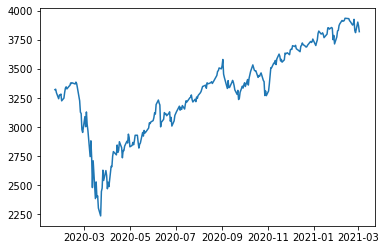

In [18]:
GSPC = yf.Ticker("^GSPC")
num_days = (dt.date(2021, 2, 1)-dt.date(2020, 1, 22)).days


snp = GSPC.history(interval="1d", start="2020-01-22").Close
#PLOT OF S&P 500
plt.plot(snp)
x = dt.date(2020, 1, 22)
date_index = pd.date_range(x, periods=num_days, freq='D')

snp = snp.reindex(index=date_index)   #gather data from 1/22/20-1/31/21
snp = snp.shift(1)     #shift to use preceding day as feature in LSTM
snp.iloc[0] = 0
snp

In [19]:
len(test_2019)

93

## Unemployment data
#### Assuming constant daily change over the course of each month

In [20]:
#Numbers from statista (https://www.statista.com/statistics/273909/seasonally-adjusted-monthly-unemployment-rate-in-the-us/)
#Jan - 3.6
#Feb - 3.5
#Mar - 4.4
#Apr - 14.7
#May - 13.3
#Jun - 11.1
#Jul - 10.2
#Aug - 8.4
#Sep - 7.8
#Oct - 6.9
#Nov - 6.7
#Dec - 6.7

def vals(initial, final, days):
    arr = [initial]
    daily_change = (final-initial)/days
    for _ in range(days-1):
        initial+=daily_change
        arr.append(initial)
    return arr

unemployment_vals =  vals(3.6, 3.5, 31) #jan  
unemployment_vals += vals(3.5, 4.4, 29) #feb
unemployment_vals += vals(4.4, 14.7, 31) #mar
unemployment_vals += vals(14.7, 13.3, 30) #apr
unemployment_vals += vals(13.3, 11.1, 31) #may
unemployment_vals += vals(11.1, 10.2, 30) #jun
unemployment_vals += vals(10.2, 8.4, 31) #jul
unemployment_vals += vals(8.4, 7.8, 31) #aug
unemployment_vals += vals(7.8, 6.9, 30) #sep
unemployment_vals += vals(6.9, 6.7, 31) #oct
unemployment_vals += vals(6.7, 6.7, 30) #nov
unemployment_vals += vals(6.7, 6.7, 31) #dec
unemployment_vals += vals(6.7, 6.7, 31) #jan

unemployment_vals = unemployment_vals[21:]


unemployment = pd.Series(data=unemployment_vals, index=date_index)
unemployment = unemployment.shift(1)
unemployment.iloc[0]=0
# plt.plot(unemployment)


## Mortgage Rates

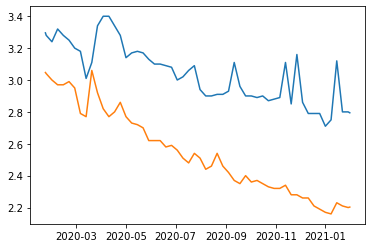

In [47]:
#http://www.freddiemac.com/pmms/
#http://www.freddiemac.com/pmms/archive.html?year=2020

#gather rates
mort_rates_2020 = pd.read_excel('/Users/daniellicht/Downloads/historicalweeklydata.xls', 'Full History')
mort_rates_2021 = pd.read_excel('/Users/daniellicht/Downloads/historicalweeklydata.xls', '1PMMS2021')
mort_rates_2020 = mort_rates_2020.iloc[2547:2598][:]
mort_rates_2021 = mort_rates_2021.iloc[0:8][:]

#combine 2020 w jan. 2021
mort_rates = pd.concat([mort_rates_2020, mort_rates_2021])

#transform 5-year rates to daily values
mort_rates_5yr = mort_rates.loc[:]["U.S. 5/1 ARM"]
mort_rates_5yr = mort_rates_5yr.iloc[:-4]
mort_rates_5yr.index = range(54)

mort_rates_daily_5yr = []
for i in range(len(mort_rates_5yr)-1):
    mort_rates_daily_5yr += vals(mort_rates_5yr[i], mort_rates_5yr[i+1], 7)

#include 1/22/20 and 1/28/20-1/31/21
mort_rates_daily_5yr.insert(0, vals(3.39, 3.28, 7)[-1])
mort_rates_daily_5yr.extend(vals(2.8, 2.78, 7)[:4])
mort_rates_daily_5yr = pd.Series(data=mort_rates_daily_5yr, index=date_index)
mort_rates_daily_5yr = mort_rates_daily_5yr.shift(1)
mort_rates_daily_5yr.iloc[0] = 0

#transform 15-year rates to daily values
mort_rates_15yr =  mort_rates.loc[:]["U.S. 15 yr FRM"]
mort_rates_15yr = mort_rates_15yr.iloc[:-4]
mort_rates_15yr.index = range(54)
mort_rates_daily_15yr = []
for i in range(len(mort_rates_15yr)-1):
    mort_rates_daily_15yr += vals(mort_rates_15yr[i], mort_rates_15yr[i+1], 7)
    
#include 1/22/20 and 1/28/20-1/31/21
mort_rates_daily_15yr.insert(0, vals(3.09, 3.04, 7)[-1])
mort_rates_daily_15yr.extend(vals(2.2, 2.21, 7)[:4])
mort_rates_daily_15yr = pd.Series(data=mort_rates_daily_15yr, index=date_index)
mort_rates_daily_15yr = mort_rates_daily_15yr.shift(1)
mort_rates_daily_15yr.iloc[0] = 0

plt.plot(mort_rates_daily_5yr.iloc[1:])
plt.plot(mort_rates_daily_15yr.iloc[1:])
plt.show()


2020-01-22            0.0
2020-01-23          557.0
2020-01-24          655.0
2020-01-25          941.0
2020-01-26         1433.0
                 ...     
2021-01-27    100269237.0
2021-01-28    100866518.0
2021-01-29    101480537.0
2021-01-30    102070241.0
2021-01-31    102585112.0
Freq: D, Length: 376, dtype: float64


In [38]:
# names = ["BTC", "BCH", "LTC", "ETC", "ADA", "EOS", "LINK", "BNB", "ZRX", "NMR", "ENJ", "SC", "BAT", "STEEM", "FUN"]
# len(names)
names = ["Currency", "Infrastructure", "Financial", "Services", "Media & Ent."]

In [39]:
# strin_vals = list(date_to_avg.values())[20:-5]  #process stringency scores for LSTM input
# strin_vals[0]=0
# stringency = pd.Series(data=strin_vals, index=date_index)
# for idx in range(len(snp)):       #fill missing daily vals w/previous day's val
#     if np.isnan(snp[idx]):
#         snp[idx] = snp[idx-1]
        
# #create map of coin names to inputs and output for each coin to be fit in LSTM
# datasets = {}
# for idx in range(len(names)):
#     #for now, skipping coins lacking sufficient datapoints
#     if names[idx]=='NMR' or names[idx]=='SC' or names[idx]=='BCH' or names[idx]=='FUN':
#         continue
#     coin_2020 = coins[idx][175:459]
# #     print(coins[idx])
#     coin_2020.index=date_index   #.set_index(index=date_index)
#     shifted_coin = coin_2020.shift(1)
#     shifted_coin.iloc[0] = 0
#     datasets[names[idx]] = pd.DataFrame({'Coin Shifted': shifted_coin, 'S&P': snp, 'Gov Stringency': stringency,  'Coin': coin_2020})
# # print(datasets['BTC'])
pct_change[0]


2020-01-22    0.007903
2020-01-23   -0.055357
2020-01-24   -0.006028
2020-01-25   -0.019910
2020-01-26    0.070645
                ...   
2021-01-27   -0.091064
2021-01-28    0.086776
2021-01-29    0.014194
2021-01-30    0.005092
2021-01-31   -0.035544
Freq: D, Name: close, Length: 376, dtype: float64

In [83]:
strin_vals = list(date_to_avg.values())[22:]  #process stringency scores for LSTM input
strin_vals.insert(0,0)
stringency = pd.Series(data=strin_vals, index=date_index)
for idx in range(len(snp)):       #fill missing daily vals w/previous day's val
    if np.isnan(snp[idx]):
        snp[idx] = snp[idx-1]
        
#create map of coin names to inputs and output for each coin to be fit in LSTM
datasets = {}
for idx in range(5):
    sector_2020 = pct_change[idx]     
    sector_2020.index=date_index   
    shifted_sector = sector_2020.shift(1)
    shifted_sector.iloc[0] = 0
    datasets[names[idx]] = pd.DataFrame({'Sector Shifted': shifted_sector,
                                         'S&P': snp,
                                         'Gov Stringency': stringency,
                                         'New Cases': global_cases,
                                         'New Deaths': global_deaths,
                                         'Unemployment': unemployment,
                                         'U.S. 5/1 ARM': mort_rates_daily_5yr,
                                         'U.S. 15 yr FRM': mort_rates_daily_15yr,
                                         'Sector': sector_2020})
print(datasets['Infrastructure'])


            Sector Shifted          S&P  Gov Stringency  New Cases  \
2020-01-22        0.000000     0.000000        0.000000      0.000   
2020-01-23       -0.004630  3321.750000        2.282337      0.000   
2020-01-24       -0.036765  3325.540039        2.624565      0.013   
2020-01-25        0.019076  3295.469971        2.851033      0.037   
2020-01-26       -0.030432  3295.469971        3.193207      0.063   
...                    ...          ...             ...        ...   
2021-01-27        0.009822  3849.620117       56.978519     71.215   
2021-01-28       -0.078110  3750.770020       57.196418     76.626   
2021-01-29        0.087187  3787.379883       56.744242     78.773   
2021-01-30        0.017557  3714.239990       56.190081     75.654   
2021-01-31        0.041003  3714.239990       56.392909     66.053   

            New Deaths  Unemployment  U.S. 5/1 ARM  U.S. 15 yr FRM    Sector  
2020-01-22       0.000      0.000000      0.000000        0.000000 -0.004630  
2

##### Example of LSTM being run on Bitcoin pricing

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
def prep(dataset):

    # scale inputs and output to [0, 1] range to improve performance
    scaled = scaler.fit_transform(dataset.values)
    inverted_X = scaler.inverse_transform(scaled)
    values = scaled

    # split into train and test sets
    train_size = int(num_days*0.6)
    test_size = num_days-train_size

    train = values[:train_size, :]

    test = values[train_size:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return inverted_X, values, train, test, train_X, train_y, test_X, test_y
inverted_X, values, train, test, train_X, train_y, test_X, test_y = prep(datasets['Infrastructure'])


In [130]:
#LSTM ARCHITECTURE
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer='adam')


es_callback1 = EarlyStopping(monitor='val_loss', patience=2.5)
es_callback2 = EarlyStopping(monitor='loss', patience=2.5)
# fit model
history = model.fit(train_X, train_y, epochs=30, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[es_callback1, es_callback2])


Epoch 1/30
57/57 - 0s - loss: 0.3970 - val_loss: 0.1953
Epoch 2/30
57/57 - 0s - loss: 0.2251 - val_loss: 0.0818
Epoch 3/30
57/57 - 0s - loss: 0.1401 - val_loss: 0.0332
Epoch 4/30
57/57 - 0s - loss: 0.1095 - val_loss: 0.0152
Epoch 5/30
57/57 - 0s - loss: 0.0929 - val_loss: 0.0100
Epoch 6/30
57/57 - 0s - loss: 0.0786 - val_loss: 0.0079
Epoch 7/30
57/57 - 0s - loss: 0.0579 - val_loss: 0.0093
Epoch 8/30
57/57 - 0s - loss: 0.0570 - val_loss: 0.0070
Epoch 9/30
57/57 - 0s - loss: 0.0544 - val_loss: 0.0068
Epoch 10/30
57/57 - 0s - loss: 0.0432 - val_loss: 0.0067
Epoch 11/30
57/57 - 0s - loss: 0.0422 - val_loss: 0.0056
Epoch 12/30
57/57 - 0s - loss: 0.0386 - val_loss: 0.0068
Epoch 13/30
57/57 - 0s - loss: 0.0319 - val_loss: 0.0057
Epoch 14/30
57/57 - 0s - loss: 0.0325 - val_loss: 0.0061


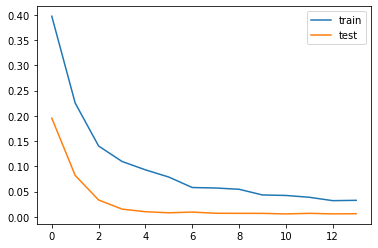

In [131]:
#GRAPH OF LOSS FUNCTIONS
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [132]:
#Currency, Financial, Infrastructure, Services, Media & Ent.
inverted_X, values, train, test, train_X, train_y, test_X, test_y = prep(datasets['Media & Ent.'])

In [133]:
#PLOT PREDICTIONS FOR ENTIRE TIME SERIES AGAINST ACTUAL VALUES
predictions = []
test_set = datasets['Media & Ent.']
for i in range(int(len(test_set.values)*0.4)):

    X, y = test[i, 0:-1], test[i, -1]
    
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    yhat = yhat[0,0]
    
    #invert scaler
    new_row = X[0][0]
    new_row = np.concatenate((new_row, [yhat]))
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    yhat = inverted[0, -1]
    yhat = yhat+inverted_X[-(len(test)-i)]
    predictions.append(yhat)


##### Predictions are blue, actual % change is red. Scales of graph are off

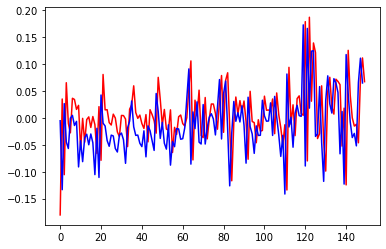

In [134]:
prediction_graph_vals = np.array([prediction[-1] for prediction in predictions])
plt.plot(inverted_X[226:,:-8], color='red') #switch 1 with 226, 301 for 80-20 split
plt.plot(prediction_graph_vals[1:], color='blue')
plt.show()

In [135]:
#     X, y = values[i, 0:-1], values[i, -1]
#     X = X.reshape(1, 1, len(X))
#     yhat = model.predict(X, batch_size=1)
#     yhat = yhat[0,0]
    
#     #invert scaler
#     new_row = X[0][0]
#     new_row = np.concatenate((new_row, [yhat]))
#     array = np.array(new_row)
#     array = array.reshape(1, len(array))
#     inverted = scaler.inverse_transform(array)
#     yhat = inverted[0, -1]
#     yhat = yhat+dataset.values[-(len(dataset.values)-i)]
#     predictions.append(yhat)
    
#RUN COMMENTED CODE TO JUST SHOW PREDICTIONS ON TEST DATA